In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import matplotlib as mpl

mpl.rcParams['font.size'] = 13

In [2]:
base_path = r"C:\Users\jorge\Documents\GitHub\Telecontrol_r\PowerSmoothing"
resultados_path = os.path.join(base_path, 'ps_data')

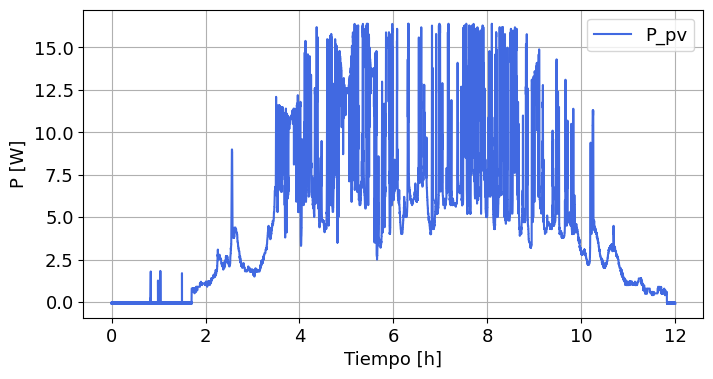

In [3]:
data_path = os.path.join(resultados_path, 'FV.txt')

with open(data_path, 'r') as file:
    # Lee todas las líneas y las almacena en una lista
    lines = file.readlines()

# Convierte las líneas en valores flotantes y almacénalos en una lista
values = [float(line.strip()) for line in lines]

# Crea el DataFrame con una columna llamada 'values'
df_data = pd.DataFrame(values, columns=['P_pv'])
df_data['Tiempo [h]'] = (df_data.index.to_numpy()) / 36000



df = df_data

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df['Tiempo [h]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)

# Añadir etiquetas y título
plt.xlabel("Tiempo [h]")
plt.ylabel("P [W]")

# Añadir leyenda
plt.legend(loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

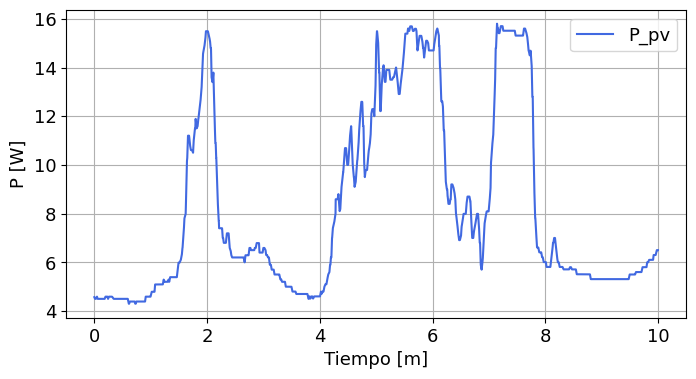

In [4]:
# df_data['Tiempo [h]'] = (df_data.index.to_numpy()) / 36000
df = df_data.iloc[164078:170078]
df = df.reset_index(drop=True)
df['Tiempo [m]'] = (df.index.to_numpy()) / 600

df_data_2 = df

# Crear la gráfica
fig, ax = plt.subplots(figsize=(8, 4))
sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)

# Añadir etiquetas y título
plt.xlabel("Tiempo [m]")
plt.ylabel("P [W]")

# Añadir leyenda
plt.legend(loc='best')

# Mostrar la gráfica
plt.grid(True)
plt.show()

# Función df

In [5]:
def create_df(P_res_array, P_sc_array, P_pv_array):
    # Verificar que los arrays tengan la misma longitud
    if len(P_res_array) == len(P_sc_array) == len(P_pv_array):
        # Crear el DataFrame
        df = pd.DataFrame({
            'P_resultante': P_res_array,
            'P_sc': P_sc_array,
            'P_pv': P_pv_array
        })
    else:
        print("Los arrays no tienen la misma longitud")
    return df

# Función Gráfico

In [6]:
def graph_min(df, name):
    df['Tiempo [m]'] = (df.index.to_numpy()) / 600
    
    # Crear la gráfica
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_sc'], color='mediumseagreen', linestyle='-', label = 'P_sc', ax=ax)
    sns.lineplot(x=df['Tiempo [m]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)
    
    # Añadir etiquetas y título
    plt.xlabel("Tiempo [m]")
    plt.ylabel("P [W]")
    
    # Añadir leyenda
    plt.legend(loc='best')
    
    plt.grid(True)
    
    # Guardar la figura
    output_path = name + ".pdf"
    plt.savefig(output_path, format='pdf', bbox_inches='tight')
    
    plt.show()

# Función Análisis

In [7]:
def analysis(df):
    # Mostrar la varianza
    v_sin_PS = round(df['P_pv'].var(),2)
    v_con_PS = round(df['P_resultante'].var(),2)
    red = round((v_sin_PS-v_con_PS)*100/v_sin_PS,2)
    print(f"Varianza sin PS: {v_sin_PS}")
    print(f"Varianza con PS: {v_con_PS}")
    print(f"Reducción de Varianza: {red} %")
    # Calcular la energía
    intervalo_tiempo = 100 / 1000  # 0.1 segundos
    energia = round((df['P_pv'].sum() * intervalo_tiempo)/3600 , 3)
    print(f"Energía de P_pv: {energia} Wh")
    energia_ps = round((df['P_resultante'].sum() * intervalo_tiempo)/3600 , 3)
    print(f"Energía de P_resultante: {energia_ps} Wh")
    print(f"Diferencia de energía: {round(energia-energia_ps,3)} Wh")

# Función Control

In [8]:
def control(selected_control):       
    global P_pvc  # Declarar como global
    global P_cov
    if selected_control == 'RR Method':
        P_sc, P_pvc = control_rr(data_array, P_pvc, SOC, rampa_base)
        P_res = P_sc + P_pv
    elif selected_control == 'Exponential Method':
        P_sc, P_pvc = control_e(data_array, P_pvc, SOC, alpha)
        P_res = P_sc + P_pv
    elif selected_control == 'Staggered Method':
        P_sc, P_pvc = control_staggered(data_array, P_pvc, SOC, rampa_base, factor_dinamico)
        P_res = P_sc + P_pv
    elif selected_control == 'Kalman Filter':
        P_sc, P_pvc, P_cov = control_Kalman(data_array, P_pvc, SOC, P_cov)
        P_res = P_sc + P_pv
    elif selected_control == 'Wiener Filter':
        P_sc, P_pvc = control_Wiener(data_array, P_pvc, SOC)
        P_res = P_sc + P_pv
    elif selected_control == 'Gaussian Filter':
        P_sc, P_pvc = control_Gaussian(data_array, P_pvc, SOC)
        P_res = P_sc + P_pv
    else:
        print("Seleccion no válida")
        
    P_res_array.append(P_res) 
    P_sc_array.append(P_sc)
    P_pv_array.append(P_pv)

# General Methods

In [9]:
from func1 import *

In [10]:
window_c1 = 3
SOC = 50

## 1 Exponential Method

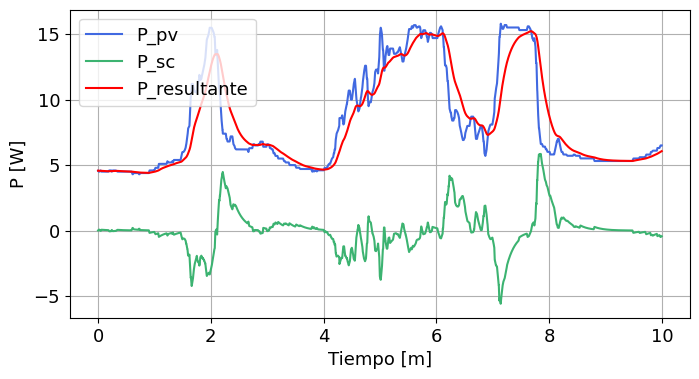

Varianza sin PS: 14.73
Varianza con PS: 12.6
Reducción de Varianza: 14.46 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [11]:
selected_control = 'Exponential Method'

alpha = 0.01
P_pvc = 4.57 # OJO se recalcula
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_1.' + selected_control)
analysis(df)

## 2 RR Method

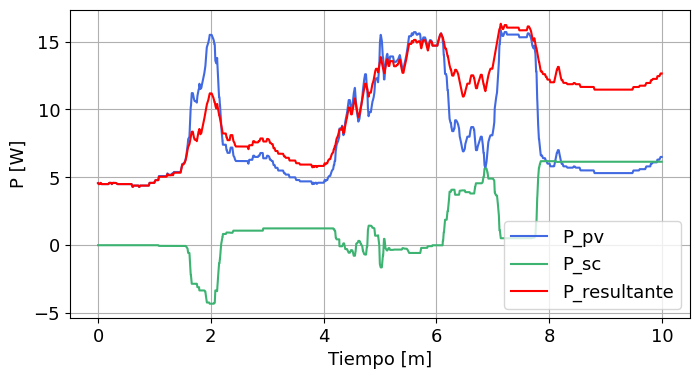

Varianza sin PS: 14.73
Varianza con PS: 12.83
Reducción de Varianza: 12.9 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.679 Wh
Diferencia de energía: -0.303 Wh


In [12]:
selected_control = 'RR Method'

P_pvc = 4.57 # OJO se recalcula
rampa_base = 0.04
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_2.' + selected_control)
analysis(df)

## 3 Staggered Method

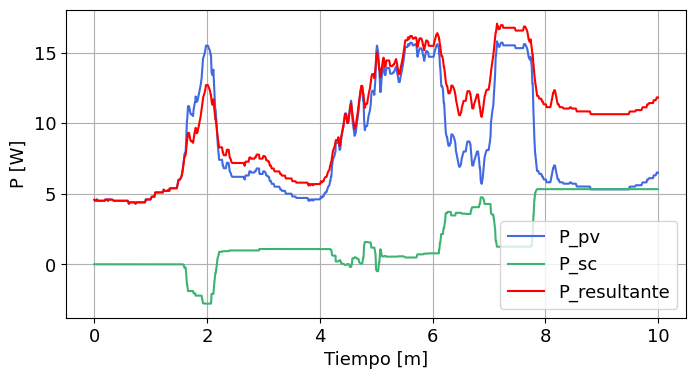

Varianza sin PS: 14.73
Varianza con PS: 13.92
Reducción de Varianza: 5.5 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.68 Wh
Diferencia de energía: -0.304 Wh


In [13]:
selected_control = 'Staggered Method'

P_pvc = 4.57 # OJO se recalcula
rampa_base = 0.04
factor_dinamico = 0.2
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_3.' + selected_control)
analysis(df)

## 4 Kalman filter

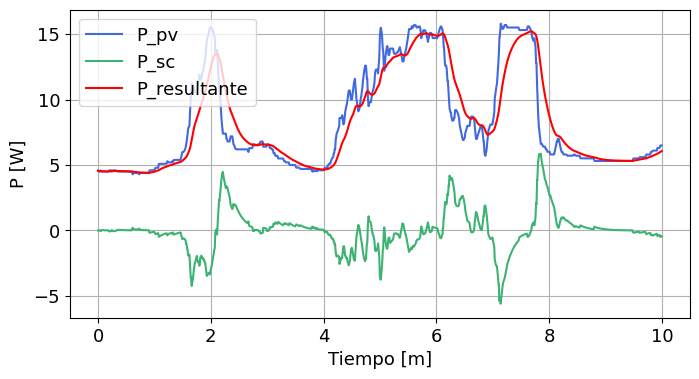

Varianza sin PS: 14.73
Varianza con PS: 12.59
Reducción de Varianza: 14.53 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [14]:
selected_control = 'Kalman Filter'

P_pvc = 4.57 # OJO se recalcula
P_cov = 1
data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_4.' + selected_control)
analysis(df)

## 5 Wiener

c:\Users\jorge\anaconda3\envs\telecontrol\lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: invalid value encountered in divide
  res *= (1 - noise / lVar)
c:\Users\jorge\anaconda3\envs\telecontrol\lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: divide by zero encountered in divide
  res *= (1 - noise / lVar)
c:\Users\jorge\anaconda3\envs\telecontrol\lib\site-packages\scipy\signal\_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


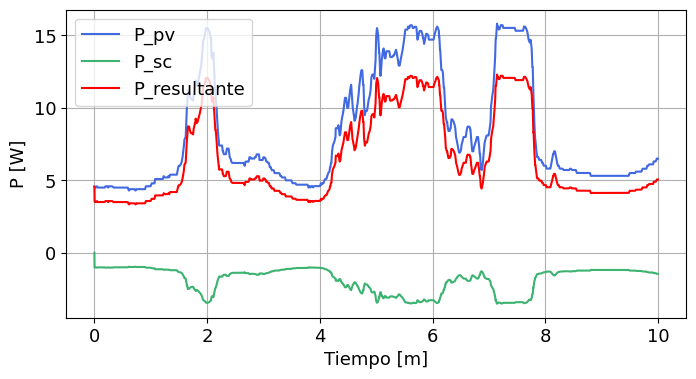

Varianza sin PS: 14.73
Varianza con PS: 8.91
Reducción de Varianza: 39.51 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.07 Wh
Diferencia de energía: 0.306 Wh


In [15]:
selected_control = 'Wiener Filter'

data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_5.' + selected_control)
analysis(df)

## 6 Gaussian Filter

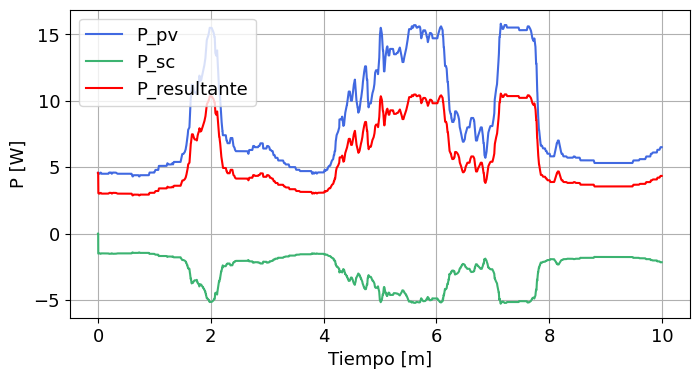

Varianza sin PS: 14.73
Varianza con PS: 6.56
Reducción de Varianza: 55.47 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 0.918 Wh
Diferencia de energía: 0.458 Wh


In [16]:
selected_control = 'Gaussian Filter'

data_array = []  # Inicializar el array para almacenar P_pv

P_res_array = []
P_sc_array = []
P_pv_array = []

for P_pv in df_data_2['P_pv']:
    
    data_array.append(P_pv)  # Agregar el valor a data_array
    if len(data_array) > window_c1:  # Mantener el array con longitud igual a window_c1
        data_array.pop(0)
    control(selected_control = selected_control)
    
df = create_df(P_res_array, P_sc_array, P_pv_array)
graph_min(df, 'simulated_6.' + selected_control)
analysis(df)

# Real Time

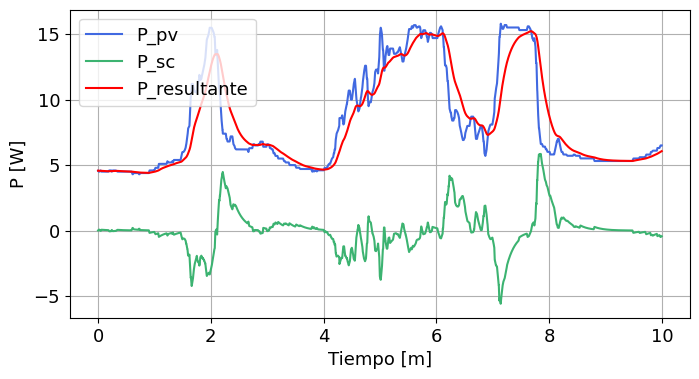

Varianza sin PS: 14.73
Varianza con PS: 12.6
Reducción de Varianza: 14.46 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [17]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.1.exponential_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df
selected_control = 'Exponential Method'
graph_min(df, 'simulated_1.' + selected_control + ' RealTime')
analysis(df)

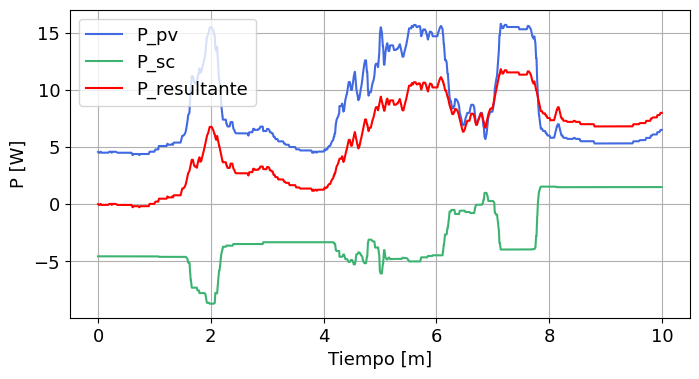

Varianza sin PS: 14.73
Varianza con PS: 12.92
Reducción de Varianza: 12.29 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 0.919 Wh
Diferencia de energía: 0.457 Wh


In [18]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.3.staggered_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Staggered Method'
graph_min(df, 'simulated_3.' + selected_control + ' RealTime')
analysis(df)

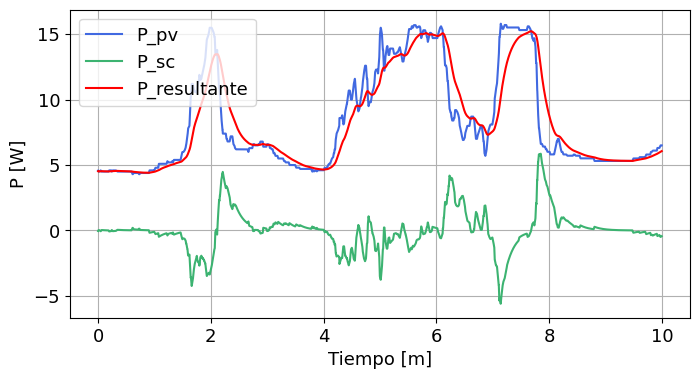

Varianza sin PS: 14.73
Varianza con PS: 12.59
Reducción de Varianza: 14.53 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.372 Wh
Diferencia de energía: 0.004 Wh


In [19]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, 'simulated_4.' + selected_control + ' RealTime')
analysis(df)

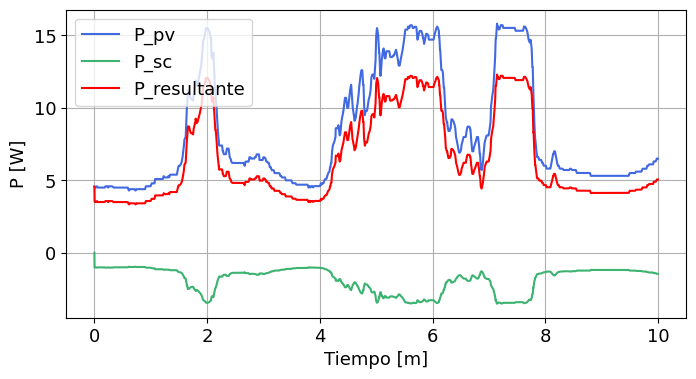

Varianza sin PS: 14.73
Varianza con PS: 8.91
Reducción de Varianza: 39.51 %
Energía de P_pv: 1.376 Wh
Energía de P_resultante: 1.07 Wh
Diferencia de energía: 0.306 Wh


In [20]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.5.Wiener_simulated.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Wiener Filter'
graph_min(df, 'simulated_5.' + selected_control + ' RealTime')
analysis(df)

In [21]:
# df = resultados_df

# df['Tiempo [h]'] = (df.index.to_numpy() + 164078) / 36000

# # Crear la gráfica
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_aux'], color='mediumseagreen', linestyle='-', label = 'P_aux', ax=ax)
# sns.lineplot(x=df['Tiempo [h]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)

# # Añadir etiquetas y título
# plt.xlabel("Tiempo [h]")
# plt.ylabel("P [W]")

# # Añadir leyenda
# plt.legend(loc='best')

# # Mostrar la gráfica
# plt.show()


In [22]:
# df = resultados_df

# # df['Tiempo [h]'] = (df.index.to_numpy() + 164078) / 36000
# df['Tiempo [m]'] = (df.index.to_numpy()) / 600

# # Crear la gráfica
# fig, ax = plt.subplots(figsize=(8, 4))
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_pv'], color='royalblue', linestyle='-', label = 'P_pv', ax=ax)
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_sc'], color='mediumseagreen', linestyle='-', label = 'P_sc', ax=ax)
# sns.lineplot(x=df['Tiempo [m]'], y=df['P_resultante'], color='red', linestyle='-', label = 'P_resultante', ax=ax)

# # Añadir etiquetas y título
# plt.xlabel("Tiempo [m]")
# plt.ylabel("P [W]")

# # Añadir leyenda
# plt.legend(loc='best')

# # Mostrar la gráfica
# plt.show()

# Real

In [23]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.1.exponential_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df
selected_control = 'Exponential Method'
graph_min(df, 'simulated_1.' + selected_control + ' Real')
analysis(df)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jorge\\Documents\\GitHub\\Telecontrol_r\\PowerSmoothing\\ps_data\\resultados.1.exponential_real.txt'

In [ ]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.3.staggered_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Staggered Method'
graph_min(df, 'simulated_3.' + selected_control + ' Real')
analysis(df)

In [ ]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.4.Kalman_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Kalman Filter'
graph_min(df, 'simulated_4.' + selected_control + ' Real')
analysis(df)

In [ ]:
# Ruta al archivo resultados.txt
resultados_file = os.path.join(resultados_path, 'resultados.5.Wiener_real.txt')
# resultados_file = os.path.join(resultados_path, 'resultados.2.exp.txt')

# Leer los datos del archivo
resultados_df = pd.read_csv(resultados_file, delim_whitespace=True)

df = resultados_df

selected_control = 'Wiener Filter'
graph_min(df, 'simulated_5.' + selected_control + ' Real')
analysis(df)